<a href="https://colab.research.google.com/github/shobhit115/HowOld.AI/blob/main/Age_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

%matplotlib inline
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten,MaxPooling2D,Input

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shobhitsingh2004","key":"cd86622aed30d13c94bce242ddd93610"}'}

In [ ]:
# STEP 2: Set up Kaggle CLI
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new



Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 86% 286M/331M [00:04<00:01, 42.4MB/s]
100% 331M/331M [00:04<00:00, 76.7MB/s]


In [ ]:
!unzip -q utkface-new.zip -d utkface_data


In [ ]:
BASE_DIR = 'utkface_data/UTKFace'


In [ ]:
image_paths =[];
age_labels = [];
gender_labels =[]
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp=filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 456154.83it/s]


In [ ]:
df= pd.DataFrame()
df['image'],df['age'],df['gender'] = image_paths,age_labels,gender_labels
df.head()

image  age  gender
0  utkface_data/UTKFace/61_0_0_20170105173233956....   61       0
1  utkface_data/UTKFace/3_0_2_20170110212616630.j...    3       0
2  utkface_data/UTKFace/27_1_0_20170103210530706....   27       1
3  utkface_data/UTKFace/24_0_4_20170117145146997....   24       0
4  utkface_data/UTKFace/25_1_1_20170116003309994....   25       1

<Axes: xlabel='age', ylabel='Density'>

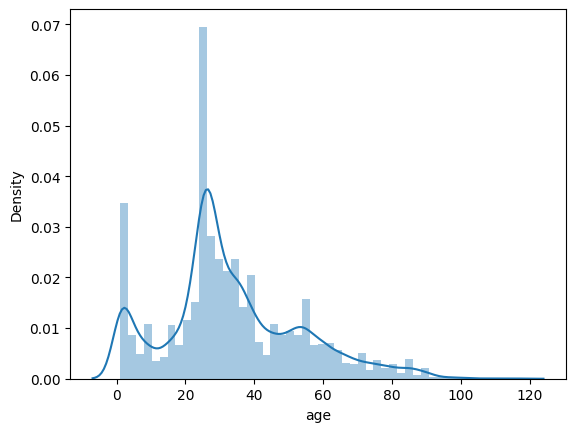

In [ ]:
sns.distplot(df['age'])

In [ ]:
gender_dict ={0:'Male', 1:'Female'}

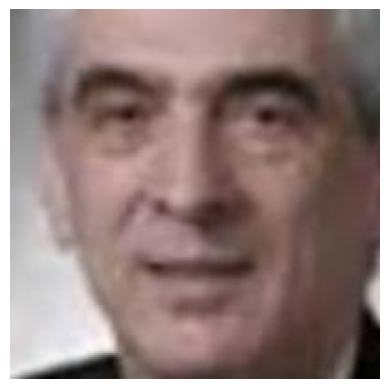

In [ ]:
from PIL import Image

img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

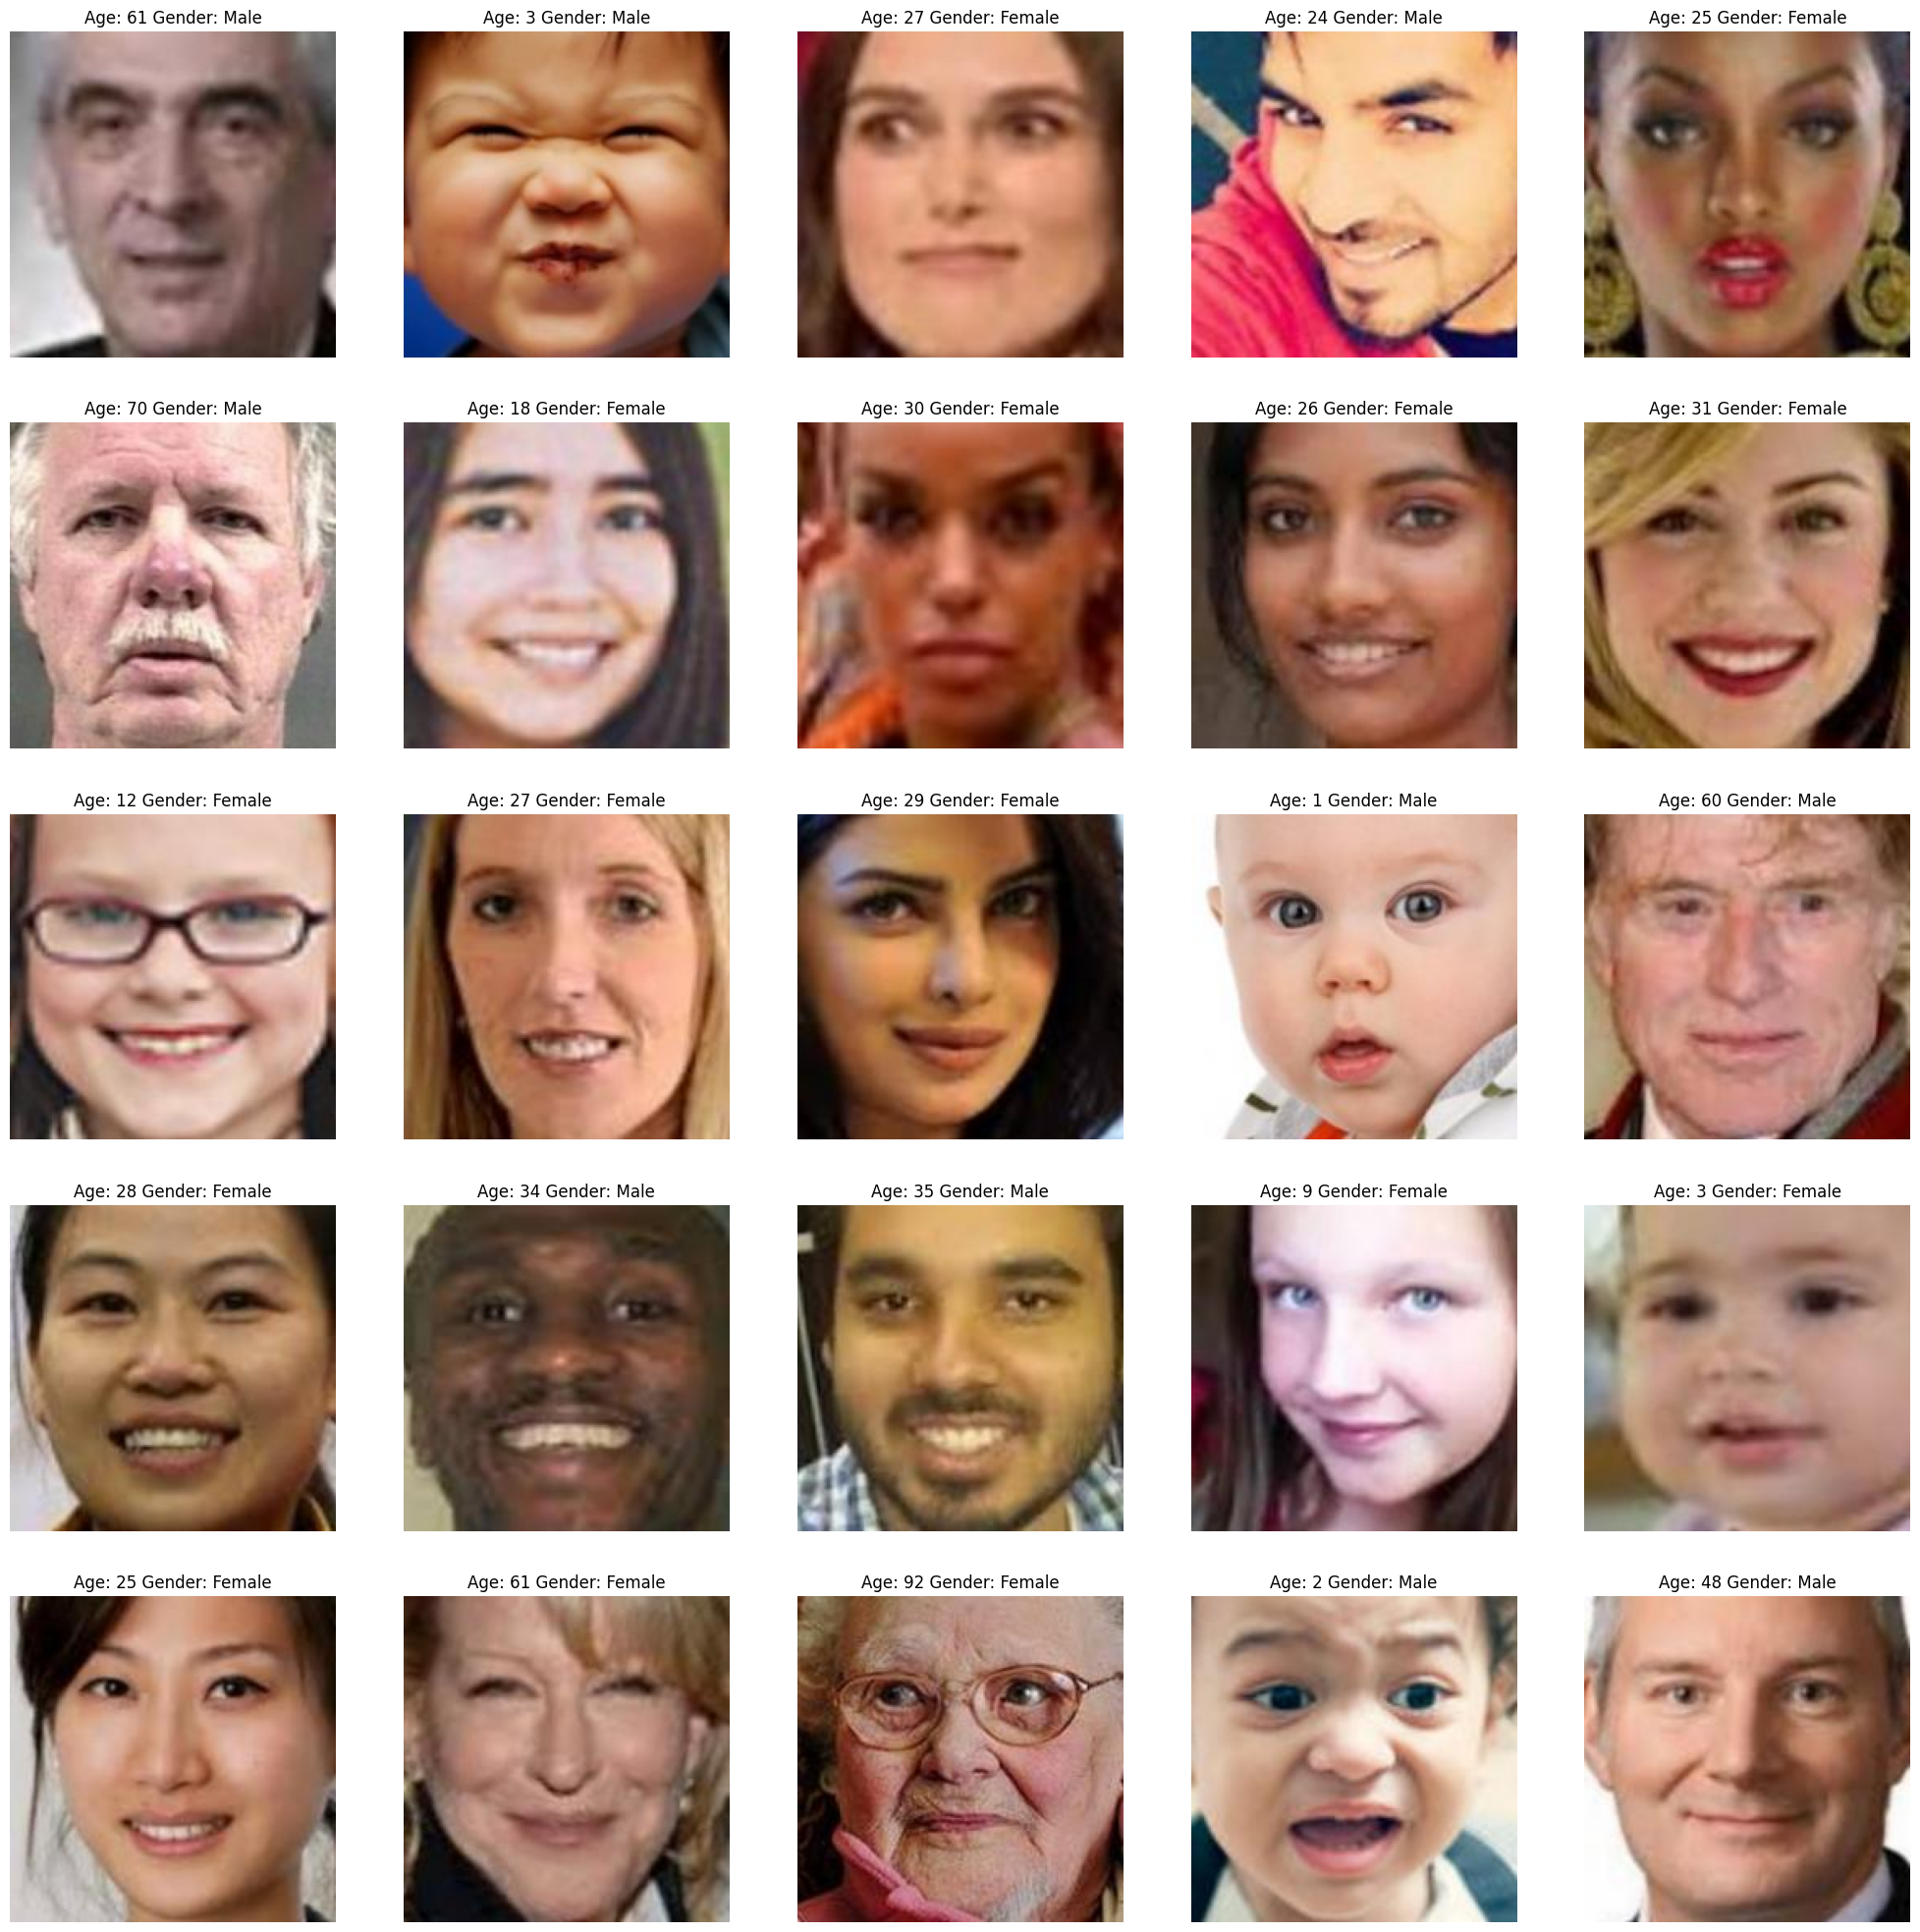

In [ ]:
# form PIL import Image
# img = Image.open(df['image'][0])
# plt.axis('off')
# plt.imshow(img)
plt.figure(figsize=(25,25))
files = df.iloc[0:25]
for index,file,age,gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, color_mode='grayscale')
    img = img.resize((128,128), resample=Image.Resampling.LANCZOS)
    img = np.array(img)
    features.append(img)
  features = np.array(features)
  features = features.reshape(len(features),128,128,1)
  return features

In [ ]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:34<00:00, 690.75it/s]


In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X=X/255.0

In [ ]:
y_gender =np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128,128,1)

MODEL CREATION

 What Does a Convolutional Layer Do?
In simple terms:

It scans small regions of an image to extract important features like edges, textures, or shapes.



What is Flatten()?
Flatten() is a layer in Keras that converts a multi-dimensional tensor into a 1D tensor (vector).

In [ ]:
input = Input(shape=input_shape)
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(32, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(32, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

dense_1 = Dense(128, activation='relu')(flatten)
dense_2 = Dense(64, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)

model = Model(inputs=input, outputs=[output_1, output_2])
# model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])
model.compile(
    loss=['binary_crossentropy', 'mae'],
    optimizer='adam',
    metrics=['accuracy', 'mae']  # One metric for each output
)


NameError: name 'Input' is not defined

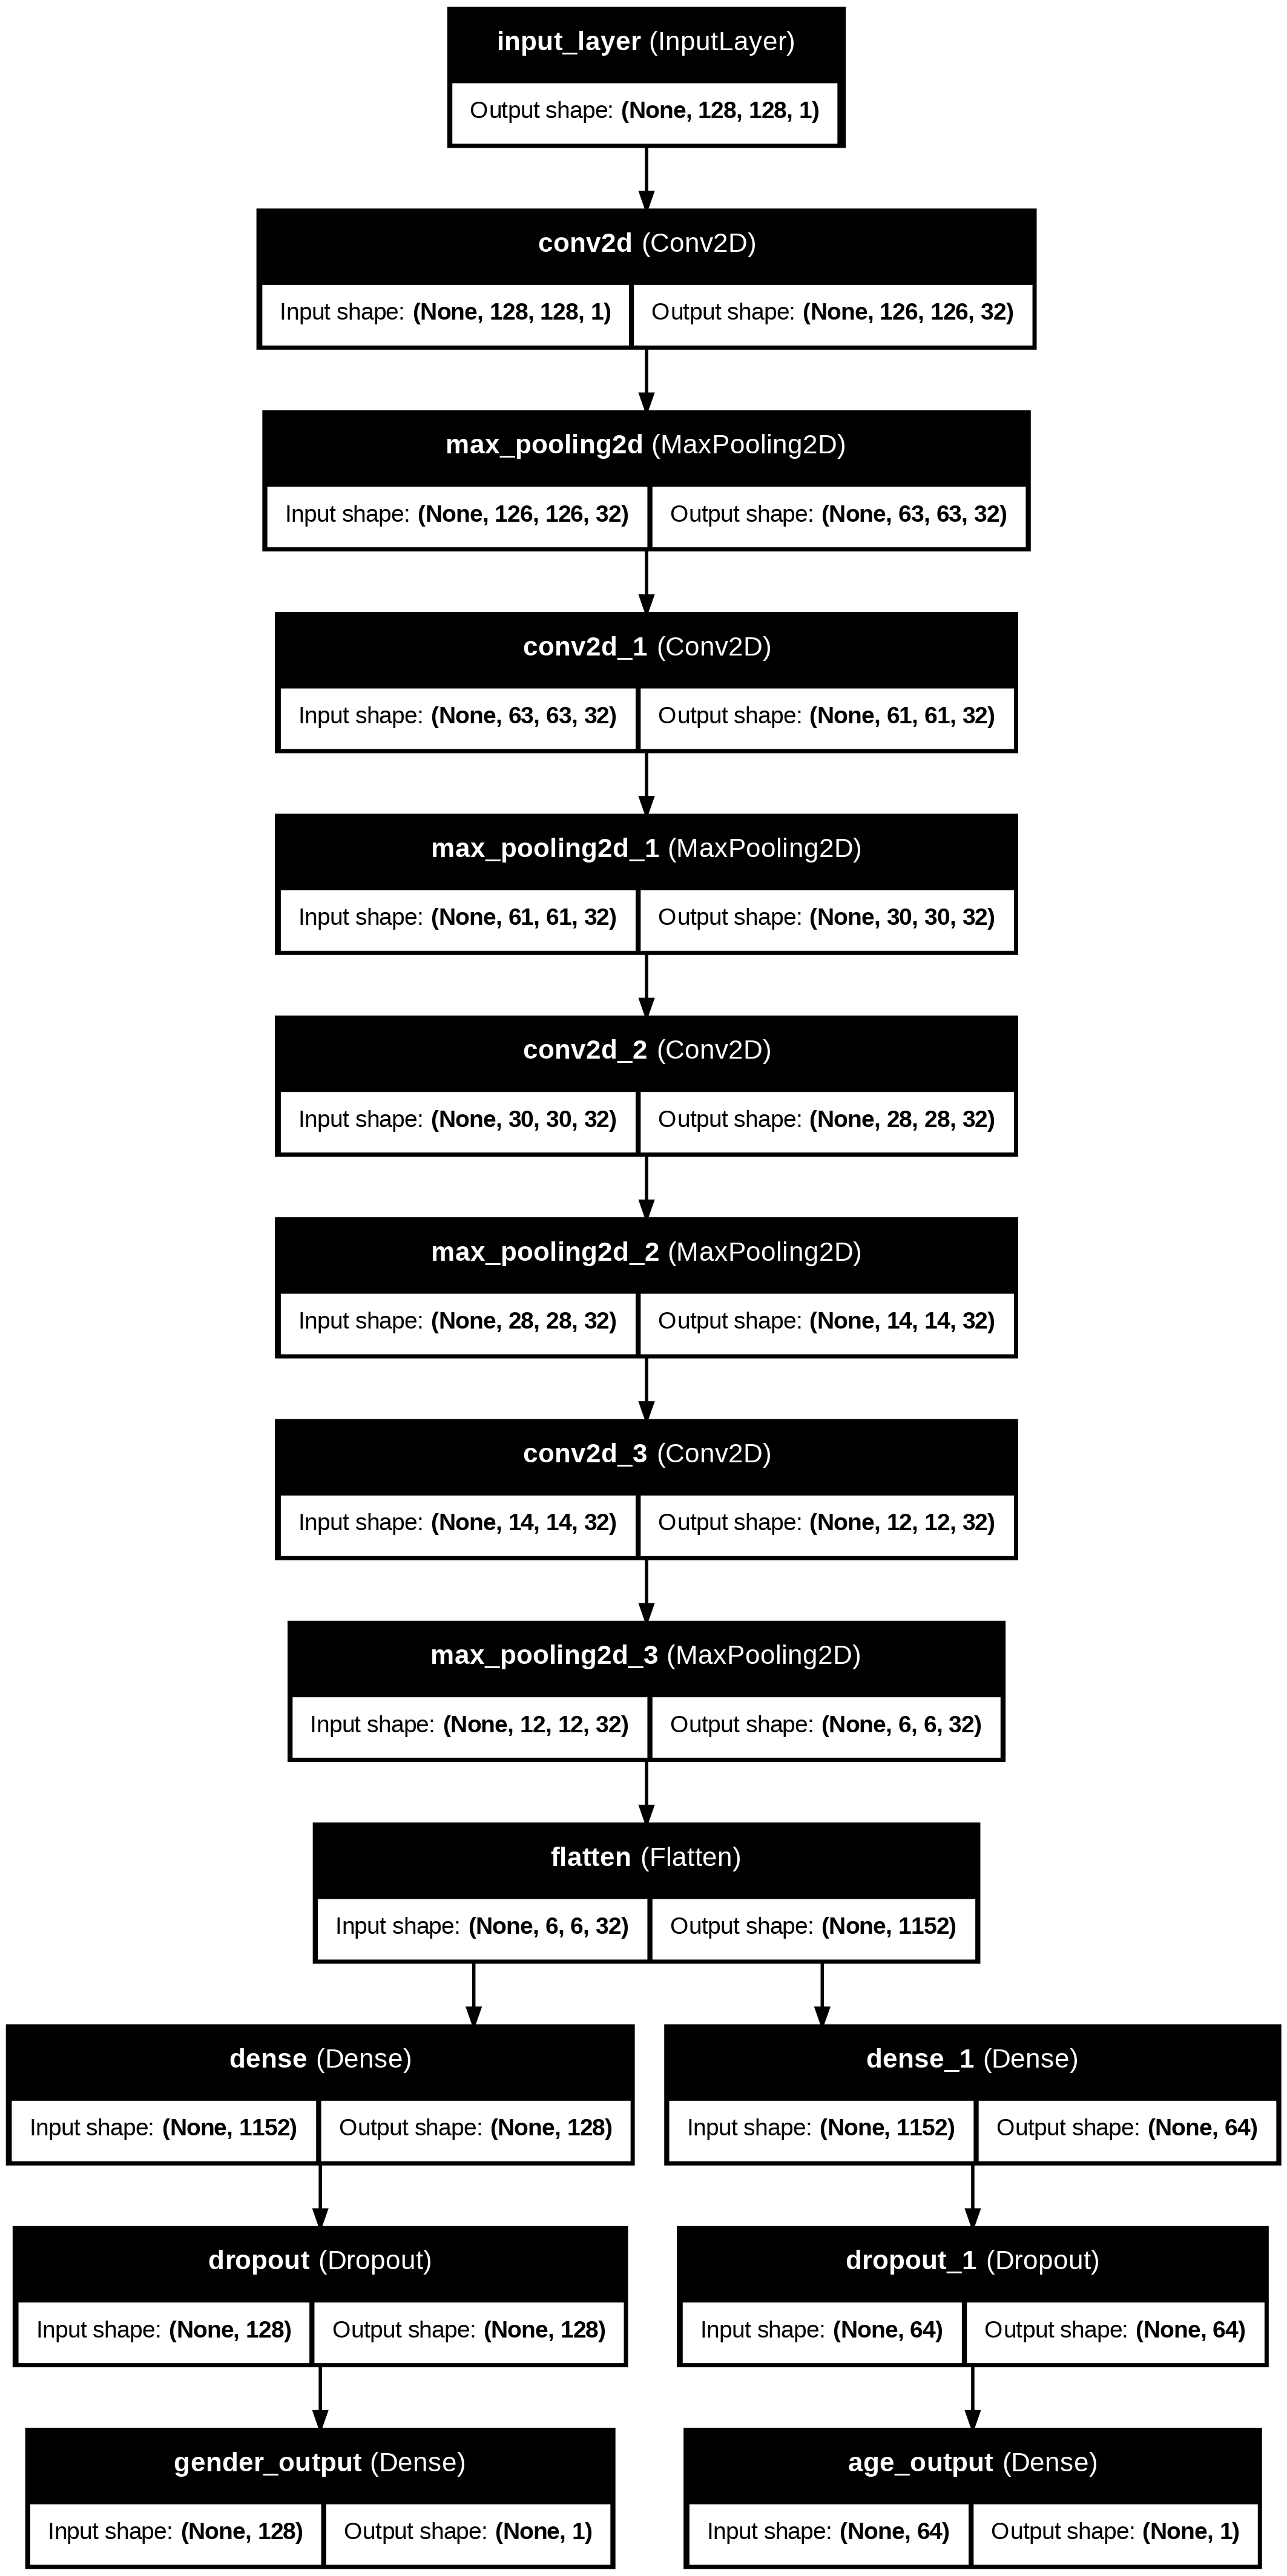

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# history = model.fit(x=X, y=[y_gender, y_age], validation_split=0.2, batch_size=32, epochs=30)
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 412s 687ms/step - age_output_loss: 17.7082 - age_output_mae: 17.7083 - gender_output_accuracy: 0.5242 - gender_output_loss: 0.7030 - loss: 18.4112 - val_age_output_loss: 14.0154 - val_age_output_mae: 13.9880 - val_gender_output_accuracy: 0.5668 - val_gender_output_loss: 0.6679 - val_loss: 14.6558
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 433s 671ms/step - age_output_loss: 14.1690 - age_output_mae: 14.1690 - gender_output_accuracy: 0.6402 - gender_output_loss: 0.6377 - loss: 14.8067 - val_age_output_loss: 11.9875 - val_age_output_mae: 12.0099 - val_gender_output_accuracy: 0.7598 - val_gender_output_loss: 0.4881 - val_loss: 12.4988
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 440s 668ms/step - age_output_loss: 11.9724 - age_output_mae: 11.9724 - gender_output_accuracy: 0.7497 - gender_output_loss: 0.5077 - loss: 12.4800 - val_age_output_loss: 11.1247 - val_age_output_mae: 11.1103 - val_gender_output_accuracy: 0.7786 - val_gender_output_loss: 0.4443 - val_

In [ ]:
# Save the trained model to a file
model.save('my_model.h5')


NameError: name 'model' is not defined

In [ ]:
from tensorflow import keras

model.save('model.keras')        # Saves architecture + weights + optimizer state
model = keras.models.load_model('model.keras')  # Properly restores the model


KeyboardInterrupt: 

In [ ]:
loss= history.history['age_output_loss']
val_loss= history.history['val_age_output_loss']
epochs=range(len(loss))
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

NameError: name 'history' is not defined

In [ ]:
image_index = 1600
print("Original Gender:",gender_dict[y_gender[image_index]],"Original Age:",y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[int(round(pred[0][0][0]))]
pred_age = int(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128,128),cmap='gray')
plt.show()

In [ ]:
from keras.preprocessing.image import img_to_array

t_image_path = '/content/Screenshot 2025-04-12 143457.png'
t_img = load_img(t_image_path, color_mode='grayscale')
t_img = t_img.resize((128,128), resample=Image.Resampling.LANCZOS)
t_img = img_to_array(t_img)  # Convert to numpy array
t_img = t_img / 255.0        # Normalize if your model was trained on normalized data
t_img = t_img.reshape(1, 128, 128, 1)  # Add batch dimension

# Predict
pred = model.predict(t_img)
pred_gender = gender_dict[int(round(pred[0][0][0]))]
pred_age = int(pred[1][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.imshow(t_img[0].reshape(128,128), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from keras.preprocessing.image import img_to_array

t_image_path = '/content/Screenshot 2025-04-12 143622.png'
t_img = load_img(t_image_path, color_mode='grayscale')
t_img = t_img.resize((128,128), resample=Image.Resampling.LANCZOS)
t_img = img_to_array(t_img)  # Convert to numpy array
t_img = t_img / 255.0        # Normalize if your model was trained on normalized data
t_img = t_img.reshape(1, 128, 128, 1)  # Add batch dimension

# Predict
pred = model.predict(t_img)
pred_gender = gender_dict[int(round(pred[0][0][0]))]
pred_age = int(pred[1][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.imshow(t_img[0].reshape(128,128), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from keras.preprocessing.image import img_to_array

t_image_path = '/content/Screenshot 2025-04-12 152751.png'
t_img = load_img(t_image_path, color_mode='grayscale')
t_img = t_img.resize((128,128), resample=Image.Resampling.LANCZOS)
t_img = img_to_array(t_img)  # Convert to numpy array
t_img = t_img / 255.0        # Normalize if your model was trained on normalized data
t_img = t_img.reshape(1, 128, 128, 1)  # Add batch dimension

# Predict
pred = model.predict(t_img)
pred_gender = gender_dict[int(round(pred[0][0][0]))]
pred_age = int(pred[1][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.imshow(t_img[0].reshape(128,128), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from keras.preprocessing.image import img_to_array

t_image_path = '/content/Screenshot 2025-04-12 143317.png'
t_img = load_img(t_image_path, color_mode='grayscale')
t_img = t_img.resize((128,128), resample=Image.Resampling.LANCZOS)
t_img = img_to_array(t_img)  # Convert to numpy array
t_img = t_img / 255.0        # Normalize if your model was trained on normalized data
t_img = t_img.reshape(1, 128, 128, 1)  # Add batch dimension

# Predict
pred = model.predict(t_img)
pred_gender = gender_dict[int(round(pred[0][0][0]))]
pred_age = int(pred[1][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.imshow(t_img[0].reshape(128,128), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from keras.preprocessing.image import img_to_array

t_image_path = '/content/Screenshot 2025-0'
t_img = load_img(t_image_path, color_mode='grayscale')
t_img = t_img.resize((128,128), resample=Image.Resampling.LANCZOS)
t_img = img_to_array(t_img)  # Convert to numpy array
t_img = t_img / 255.0        # Normalize if your model was trained on normalized data
t_img = t_img.reshape(1, 128, 128, 1)  # Add batch dimension

# Predict
pred = model.predict(t_img)
pred_gender = gender_dict[int(round(pred[0][0][0]))]
pred_age = int(pred[1][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.imshow(t_img[0].reshape(128,128), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from keras.preprocessing.image import img_to_array

t_image_path = '/content/IMG_20250428_113314.jpg'
t_img = load_img(t_image_path, color_mode='grayscale')
t_img = t_img.resize((128,128), resample=Image.Resampling.LANCZOS)
t_img = img_to_array(t_img)  # Convert to numpy array
t_img = t_img / 255.0        # Normalize if your model was trained on normalized data
t_img = t_img.reshape(1, 128, 128, 1)  # Add batch dimension

# Predict
pred = model.predict(t_img)
pred_gender = gender_dict[int(round(pred[0][0][0]))]
pred_age = int(pred[1][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.imshow(t_img[0].reshape(128,128), cmap='gray')
plt.axis('off')
plt.show()